In [1]:
from qiskit import IBMQ, transpiler, transpile, QuantumCircuit, schedule
from qiskit.visualization import plot_gate_map
from qiskit.visualization.pulse_v2 import IQXStandard, draw
from qiskit.tools.jupyter import *
from IPython.display import display, Math
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
provider = IBMQ.enable_account('51057eaa66f88664f054b9a73766c53de4859a3e97c7f912cd975db51e3c9f67f9207c2833555417a8af276f7109783931401df61da2a785d595e8f429ce4309')

# ibmq_lima general info

In [4]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

# Basis gates

In [5]:
# Get the device basis gates

basis_gates = backend.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

# T1 and T2 times

In [6]:
# T1 and T2 times of each qubit

for i in range(backend.configuration().num_qubits):
    qubit_data = backend.properties().qubits[i]
    T1_dict = qubit_data[0].to_dict()
    T2_dict = qubit_data[1].to_dict()
    T1_value = T1_dict["value"]
    T2_value = T2_dict["value"]
    print("Qubit",i)
    print("{: >14} {: >21}".format("T1 =", str(T1_value)+" us"))
    print("{: >14} {: >21}".format("T2 =", str(T2_value)+" us"))
    

Qubit 0
          T1 = 130.31532130792272 us
          T2 = 211.42475711918954 us
Qubit 1
          T1 =  73.11076527625742 us
          T2 =  77.68839669513608 us
Qubit 2
          T1 =  71.81640620298018 us
          T2 = 116.41052696043943 us
Qubit 3
          T1 =  80.42816211303352 us
          T2 =   86.3955090285432 us
Qubit 4
          T1 = 22.848537195304715 us
          T2 = 23.705788533202295 us


# Gates duration (for Table III)
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [7]:
# Get duration of instructions on a qubit

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

# Print the durations

print("{: >31} {: >29} {: >25}".format("Time scale of the backend: dt =", str(dt_in_s*1e6)+" us =", str(dt_in_s*1e9)+" ns\n"))
print("{: >31} {: >29} {: >24}".format("I gate duration =", str(dt_in_s*I_duration*1e6)+" us =", str(I_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("Z gate duration =", str(dt_in_s*Z_duration*1e6)+" us =", str(Z_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("SX gate duration =", str(dt_in_s*SX_duration*1e6)+" us =", str(SX_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("X gate duration =", str(dt_in_s*X_duration*1e6)+" us =", str(X_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("Y gate duration =", str(dt_in_s*Y_duration*1e6)+" us =", str(Y_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("H gate duration =", str(dt_in_s*H_duration*1e6)+" us =", str(H_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("Measurement duration q1 =", str(dt_in_s*Measurement_duration*1e6)+" us =", str(Measurement_duration)+" dt"))
print("{: >31} {: >29} {: >24}".format("Measurement duration q3 =", str(dt_in_s*Measurement_duration3*1e6)+" us =", str(Measurement_duration3)+" dt"))

print()

# Get and print the duration of the CNOT gates for each connected qubit pair

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
    print("{: >31} {: >29} {: >24}".format("CNOT " + str(pair) + " gate duration =", str(dt_in_s*CNOT_pair_duration*1e6)+" us =", str(CNOT_pair_duration)+" dt"))
CNOT_durations = dict(CNOT_durations)

Time scale of the backend: dt =    0.0002222222222222222 us =    0.2222222222222222 ns

              I gate duration =     0.035555555555555556 us =                   160 dt
              Z gate duration =                      0.0 us =                     0 dt
             SX gate duration =     0.035555555555555556 us =                   160 dt
              X gate duration =     0.035555555555555556 us =                   160 dt
              Y gate duration =      0.07111111111111111 us =                   320 dt
              H gate duration =     0.035555555555555556 us =                   160 dt
      Measurement duration q1 =        5.351111111111111 us =                 24080 dt
      Measurement duration q3 =        5.351111111111111 us =                 24080 dt

    CNOT [0, 1] gate duration =      0.30577777777777776 us =                  1376 dt
    CNOT [1, 0] gate duration =       0.3413333333333333 us =                  1536 dt
    CNOT [1, 2] gate duration =       0.3

# Hamiltionian of the device

In [8]:
# Get the information about the device Hamiltonian
backend.configuration().hamiltonian

{'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\n\nQuantities are returned in angular frequencies, with units 2*pi*GHz.\n\nWARNING: Currently not all system Hamiltonian information is available

In [9]:
# Print the Hamiltonian nicely
display(Math(backend.configuration().hamiltonian["h_latex"])) 
# Print nicely the transformations used in the Hamiltonian
display(Math("$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Topology/connectivity

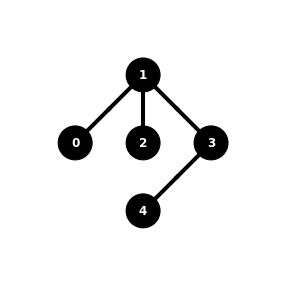

In [10]:
# Plot a Gate Map for the device.
""" 
# For LaTeX font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold",
    "font.sans-serif": ["Computer Modern Roman"]})
"""
#plt.rcdefaults()
fig = plot_gate_map(backend, plot_directed=False, font_color="white", qubit_color=["black"]*5, line_color=["black"]*8)#, font_size=32)
#fig.savefig(r'gate_map_lima.pdf')
fig

# Calibrations

In [11]:
# Get the historical calibrations data.

dates = []
for i in range(10, 16+1):
    if i==15:
        dates.append(datetime(day=i, month=8, year=2022, hour=0))
    else:
        for h in [0, 3, 6, 9, 12, 15, 18, 21]:
            dates.append(datetime(day=i, month=8, year=2022, hour=h))

historical_backend_props = []
for date in dates:
    historical_backend_props.append(backend.properties(datetime=date))

# Retrieve the data.

T1s = []
T2s = []

for i in range(len(dates)):
    T1s.append(1e6*np.average([
        historical_backend_props[i].t1(0),
        historical_backend_props[i].t1(1),
        historical_backend_props[i].t1(2),
        historical_backend_props[i].t1(3),
        historical_backend_props[i].t1(4)
        ]))
    T2s.append(1e6*np.average([
        historical_backend_props[i].t2(0),
        historical_backend_props[i].t2(1),
        historical_backend_props[i].t2(2),
        historical_backend_props[i].t2(3),
        historical_backend_props[i].t2(4)
        ]))

backend_data = [T1s, T2s]

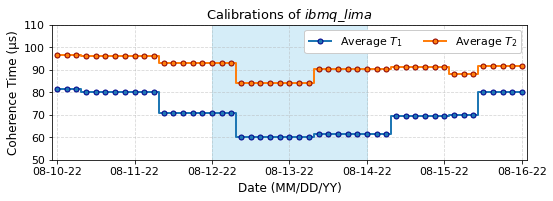

In [12]:
fig, ax = plt.subplots(figsize=(7.8,2.9), ncols=1, nrows=1, sharex=True)

xaxis = np.arange(len(dates))
xaxis_fill = np.arange(2*len(dates))/2
xticklabels_list = [str(dates[i])[5:-9] for i in range(len(dates))]
for i in range(len(xticklabels_list)):
    xticklabels_list[i] = xticklabels_list[i]+"-22"

plotted_qubits = [0,4]
colors = ["C0", "C1"]
fs = 12

T1, T2 = backend_data
    
ax.set_xticks(xaxis[::8])
ax.set_xticklabels(xticklabels_list[::8], rotation=0)
ax.set_xlabel(r"Date (MM/DD/YY)", fontsize=fs)
ax.set_ylabel("Coherence Time (μs)", fontsize=fs)

ax.set_title(r"Calibrations of $\it{ibmq\_lima}$", fontsize=fs+1)

ax.step(xaxis, T1, 
        where="mid", 
        marker="o", markerfacecolor=colors[0], markeredgecolor="darkblue", markersize=5, markeredgewidth=1, 
        label=r"Average $T_1$", 
        color=colors[0], 
        alpha=1, 
        lw=2)

ax.step(xaxis, T2, 
        where="mid", 
        marker="o", markerfacecolor=colors[1], markeredgecolor="darkred", markersize=5, markeredgewidth=1, 
        label=r"Average $T_2$", 
        color=colors[1], 
        alpha=1, 
        lw=2)

ax.fill_between(xaxis_fill[len(xaxis_fill)//2-17:len(xaxis_fill)//2+16], 0, 200, 
                color="skyblue", 
                alpha=0.35, 
                zorder=1)

ax.set_ylim(ymin=50, ymax=110)   
ax.set_xlim((-0.5,len(dates)-0.5))
ax.legend(framealpha=1, ncol=len(plotted_qubits), fontsize=fs-1)
ax.grid(ls="--", alpha=0.5)
ax.tick_params(axis='both', labelsize=fs-1)
    
plt.tight_layout()
plt.show()
#plt.savefig(r"lima_calibrations.pdf")

# Single-qubit properties (Table 1)

In [13]:
date = datetime(day=13, month=8, year=2022, hour=12)
props = backend.properties(datetime=date)

qubits = [0,1,2,3,4]
for q in qubits:
    # Print for LaTeX
    print(str(q) 
          + " & " + str(np.round(props.t1(q)*1e6,2))
          + " & " + str(np.round(props.t2(q)*1e6,2))
          + " & " + str(np.round(props.frequency(q)*1e-9,3))
          + " & " + str(np.round(props.qubits[q][3].value,6))
          + " & " + str(np.round(props.readout_error(q),6))
          + " & " + str(np.round(props.gate_error("x",q),6)) 
          + r" \\"
          )

0 & 54.89 & 132.21 & 5.03 & -0.335742 & 0.0207 & 0.000425 \\
1 & 91.51 & 106.43 & 5.128 & -0.318349 & 0.0152 & 0.000555 \\
2 & 72.49 & 105.08 & 5.247 & -0.333604 & 0.0232 & 0.000673 \\
3 & 67.27 & 80.2 & 5.303 & -0.331242 & 0.0312 & 0.000288 \\
4 & 21.93 & 27.24 & 5.092 & -0.33447 & 0.0517 & 0.000631 \\


# Pulses (Fig. 3)

In [14]:
# Define a custom style for the plots (colors, fontsize, etc)
my_style = {
    'formatter.general.fig_width': 20,
    "formatter.text_size.frame_change":22,
    "formatter.text_size.annotate": 12,
    "formatter.text_size.gate_name": 15,
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C',
        'sx': '#DC143C',
        'reset': '#a0a0a0',
        'measure': '#a0a0a0' 
        },
    "formatter.color.waveforms":
    {
    'W': ['#648fff', '#002999'],
    'D': ['#648fff', '#002999'],
    'U': ['#ffb000', '#994A00'],
    'M': ['#dc267f', '#760019'],
    'A': ['#dc267f', '#760019']
    },
    "formatter.text_size.fig_title":14,
    "formatter.text_size.axis_label":14,
}

style = IQXStandard(**my_style)

### Y gate

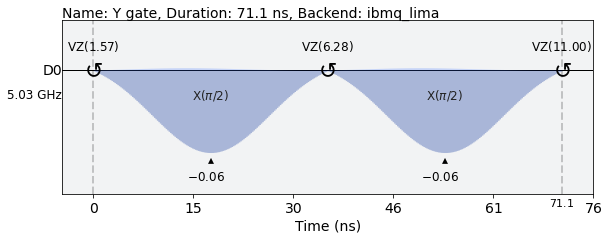

In [15]:
qc = QuantumCircuit(1, name="Y gate")
qc.y(0)
qc = transpile(qc, backend, optimization_level=0)
sched = schedule(qc, backend)

dt=2/9 #ns

fig, ax = plt.subplots(figsize=(8,3))
ax.axvline(0, ls="--", alpha=0.2, c="k", lw=2)
ax.axvline(320, ls="--", alpha=0.2, c="k", lw=2)
plt.tight_layout()
ax.annotate("$71.1$", (320,-1.75), fontsize=11, ha='center',annotation_clip=False)
ax.annotate(r"$\blacktriangle$", (320//4,-1.23), fontsize=12, ha='center')
ax.annotate("$-0.06$", (320//4-3,-1.43), fontsize=12, ha='center')
ax.annotate(r"$\blacktriangle$", (3*320//4,-1.23), fontsize=12, ha='center')
ax.annotate("$-0.06$", (3*320//4-3,-1.43), fontsize=12, ha='center')
#fig.suptitle("Duration: 71.1 ns. Backend: ibmq_lima")
draw(sched, backend=backend, style=style, 
     plotter="mpl2d", axis=ax, show_snapshot=True, 
     show_waveform_info=True, time_range=(-5,325))#.savefig(r"YgatePulseSchedule.svg")


### X gate

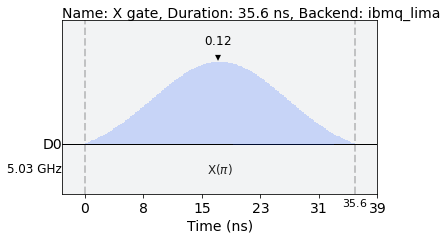

In [16]:
qc = QuantumCircuit(1, name="X gate")
qc.x(0)
qc = transpile(qc, backend, optimization_level=0)
sched = schedule(qc, backend)

dt=2/9 #ns

fig, ax = plt.subplots(figsize=(5,3))
ax.axvline(0, ls="--", alpha=0.2, c="k", lw=2)
ax.axvline(160, ls="--", alpha=0.2, c="k", lw=2)
plt.tight_layout()
ax.annotate("$35.6$", (160,-1.75), fontsize=11, ha='center',annotation_clip=False)
ax.annotate(r"$\blacktriangledown$", (160//2-1,0.02), fontsize=12, ha='center')
ax.annotate("$0.12$", (160//2-1,0.21), fontsize=12, ha='center')
draw(sched, backend=backend, style=style, 
     plotter="mpl2d", axis=ax, show_snapshot=True, 
     show_waveform_info=True, time_range=(-5,165))#.savefig(r"XgatePulseSchedule.svg")